In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize , poly)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF 
from statsmodels.stats.anova import anova_lm

from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
dflt = load_data('Default')
dflt.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [4]:
allvars = dflt.columns.drop(['student', 'default'])
allvars
design = MS(allvars)
X = design.fit_transform(dflt)
y = dflt.default == 'Yes'

glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-11.540500,0.435000,-26.544,0.0
balance,0.005600,0.000000,24.835,0.0
income,0.000021,0.000005,4.174,0.0


In [5]:
probs = results.predict()
probs.shape[0]
labels = np.array(['Yes']*10000)
labels[probs<0.5] = 'No'

# labels[:100]

confusion_table(labels, dflt.default)
np.mean(labels == dflt.default)

0.9737

In [6]:
train = (dflt.index < 5000)

design = MS(['balance', 'income']).fit(dflt)

# Add student dummy variable

# def binarize(x):
#     if x == 'Yes':
#         return 1
#     else:
#         return 0
    
# dflt.student = dflt.student.apply(lambda x: binarize(x))
    
# design = MS(['balance', 'income', 'student']).fit(dflt)

X = design.transform(dflt)
y = dflt.default == 'Yes'

X_train, X_test = X.loc[train], X.loc[~train]
# X_train, X_test = [M.drop(columns=['intercept'])
#                    for M in [X_train, X_test]]
y_train, y_test = y.loc[train], y.loc[~train]



In [7]:
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)


labels = np.array(['Yes']*probs.shape[0])
labels[probs<0.5] = 'No'


D = dflt.default
L_train, L_test = D.loc[train], D.loc[~train]

confusion_table(labels, L_test)

np.mean(labels == L_test)

# Adding student dummy variable decreases accoracy to 0.9738

0.9742

# Estimating variance of regression coefficients

In [8]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                 5000
Model:                            GLM   Df Residuals:                     4997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -398.55
Date:                Wed, 06 Sep 2023   Deviance:                       797.11
Time:                        10:42:48   Pearson chi2:                 3.33e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1341
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -11.9789      0.628    -19.078      0.000     -13.210     -10.748
balance        0.0058      0.000     18.013      0.000       0.005       0.006
income      2.885e-05   7.06e-06      4.086      0.000     1.5e-05    4.27e-05
==============================================================================
"""

In [9]:
def boot_fn(D, idx):
    design = MS(['balance', 'income']).fit(D)
    X = design.transform(D)
    y = D.default == 'Yes'
    X = X.loc[idx]
    y = y.loc[idx]
    glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
    results = glm.fit()
    return results.params
    
rng = np.random.default_rng(0)
idx = rng.choice(dflt.index,
                         dflt.shape[0],
                         replace=True)

boot_fn(dflt, idx)

def coeff_SE(n, D):
    intercept = []
    balance = []
    income = []
    for _ in range(n):
        rng = np.random.default_rng()
        idx = rng.choice(dflt.index,
                                dflt.shape[0],
                                replace=True)
        params = boot_fn(D, idx)
        # print(params)
        intercept.append(params[0])
        balance.append(params[1])
        income.append(params[2])

    income = np.array(income)
    balance = np.array(balance)
    intercept = np.array(intercept)

    return intercept.mean(), balance.mean(), income.mean()

coeff_SE(100, dflt)
# dflt.loc[[1,1,1]]    

(-11.499596280385454, 0.005622282487590173, 2.0904408183699818e-05)

In [10]:
weekly = load_data('Weekly')
weekly.head()

design = MS(['Lag1', 'Lag2']).fit(weekly)
X = design.transform(weekly)
y = weekly.Direction == 'Up'

glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()

probs = results.predict()
probs.shape[0]
labels = np.array(['Down']*1089)
labels[probs>0.5] = "Up"

confusion_table(labels, weekly.Direction)

Truth,Down,Up
Predicted,,
Down,38,38
Up,446,567


In [11]:
# All but first

X_train, X_test = X.loc[1:], X.loc[0]
y_train, y_test = y.loc[1:], y.loc[0]

glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

D = weekly.Direction
L_train, L_test = D.loc[1:], D.loc[0]

labels = np.array(['Down']*1)
labels[probs>0.5] = 'Up'
# confusion_table(labels, L_test)

print(labels, probs, L_test, '\n')

print(labels == L_test)

['Up'] None    0.571392
dtype: float64 Down 

[False]


In [12]:
# LOOCV

post_probs = []
err_vect = []

# X.shape[0]

for i in range(X.shape[0]):
    X_train, X_test = X[X.index != i], X.loc[i]
    y_train, y_test = y.loc[y.index != i], y.loc[i]

    glm_train = sm.GLM(y_train,
                    X_train,
                    family=sm.families.Binomial())
    results = glm_train.fit()
    probs = results.predict(exog=X_test)

    # D = weekly.Direction
    # L_train, L_test = D.loc[1:], D.loc[0]

    # labels = np.array(['Down']*1)
    # labels[probs>0.5] = 'Up'
    post_probs.append(probs[0])
    if probs[0] > 0.5:
        resp = 1
    else:
        resp = 0

    if resp != y_test:
        err_vect.append(1)
    else:
        err_vect.append(0)
    # print(resp, y_test)

np.array(err_vect).mean()


0.44995408631772266

<Axes: xlabel='x', ylabel='y'>

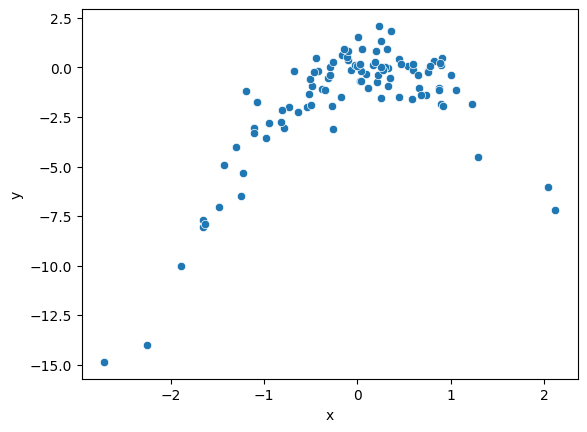

In [13]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

df = pd.DataFrame({'x': x, 'y': y})
# df = df.sort_values(by='x', axis=0, ascending=True)
# df.head(10)

sns.scatterplot(data=df, x='x', y='y')

1.1229368563419686

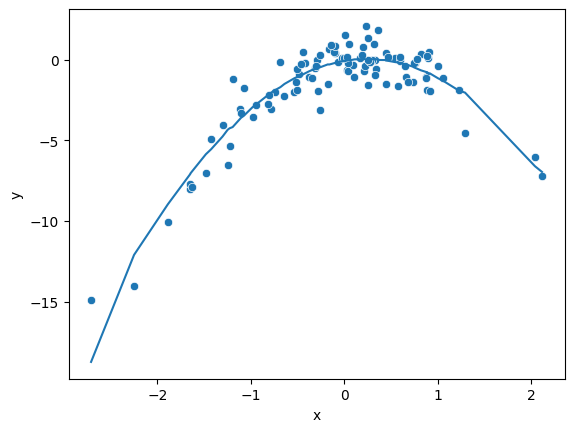

In [16]:
df['x2'] = df.x**2
df['x3'] = df.x**3
df['x4'] = df.x**4

design = MS(['x', 'x2']).fit(df)
X = design.transform(df)
y = df.y

post_pred = []
err_vect = []
for i in range(X.shape[0]):
    X_train, X_test = X[X.index != i], X.loc[i]
    y_train, y_test = y.loc[y.index != i], y.loc[i]

    model = sm.OLS(y_train, X_train)
    results = model.fit()
    # print(results.summary())
    
    pred = results.predict(exog=X_test)

    post_pred.append(pred[0])
    # print(pred[0], y_test)
    err_vect.append((pred[0] - y_test)**2)


df['pred'] = np.array(post_pred)

sns.scatterplot(data=df, x='x', y='y')
sns.lineplot(data=df, x='x', y='pred')

np.array(err_vect).mean()

In [17]:
bstn = load_data('Boston')
bstn.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [18]:
bstn['medv'].mean()

22.532806324110677

In [23]:
# SE
import math
f"std: {bstn['medv'].std()}, standard error of population (estimate): {bstn['medv'].std()/math.sqrt(bstn.shape[0])}"

'std: 9.197104087379818, standard error of population (estimate): 0.40886114749753505'

In [64]:
# Estimate using bootstrap

def bootstrap(D, col, idx, func):
    return func(D[col].loc[idx])

def func_mean(series):
    return series.mean()


def func_median(series):
    return series.median()

def func_10th_percentile(series):
    return np.percentile(series, 10)

def estim(D, col, func, n):
    estimate = []
    for i in range(n):
        rng = np.random.default_rng()
        idx = rng.choice(D.index,
                            D.shape[0],
                            replace=True)
        elem = bootstrap(D, col, idx, func)
        estimate.append(elem)

    return np.array(estimate), np.array(estimate).mean(), np.array(estimate).std()

In [65]:
# Mean

estim(bstn, 'medv', func_mean, 100)[1:]

(22.518009881422923, 0.3554685060333441)

In [66]:
# Median

estim(bstn, 'medv', func_median, 100)[1:]
# bstn['medv'].median()

(21.1675, 0.4013337140086784)

In [74]:
# 10th percentile 

np.percentile(bstn['medv'], 10)

estim(bstn, 'medv', func_10th_percentile, 100)[1:]

(12.850999999999997, 0.5044293805876101)